In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

# Modelado
# ==============================================================================
from sklearn.datasets import make_blobs
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

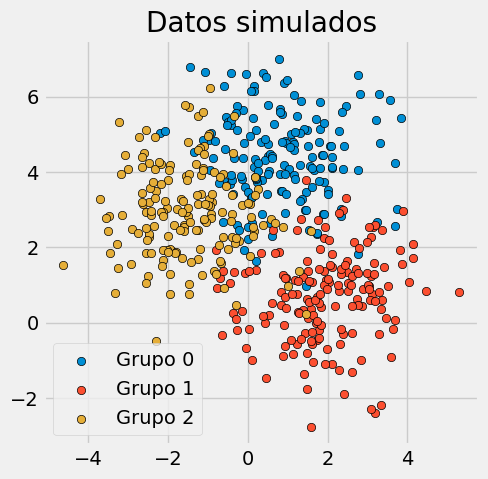

In [2]:
# Datos simulados
# ==============================================================================
X, y = make_blobs(
        n_samples    = 500, 
        n_features   = 2, 
        centers      = 3, 
        cluster_std  = 1.2, 
        shuffle      = True, 
        random_state = 0
       )

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in np.unique(y):
    ax.scatter(
        x = X[y == i, 0],
        y = X[y == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Grupo {i}"
    )
    
ax.set_title('Datos simulados')
ax.legend();

In [3]:
# Modelos
# ==============================================================================
modelo_1 = MLPClassifier(
                hidden_layer_sizes=(5),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 1000,
                random_state = 123
            )

modelo_2 = MLPClassifier(
                hidden_layer_sizes=(10),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 1000,
                random_state = 123
            )

modelo_3 = MLPClassifier(
                hidden_layer_sizes=(20, 20),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 5000,
                random_state = 123
            )

modelo_4 = MLPClassifier(
                hidden_layer_sizes=(50, 50, 50),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 5000,
                random_state = 123
            )

modelo_1.fit(X=X, y=y)
modelo_2.fit(X=X, y=y)
modelo_3.fit(X=X, y=y)
modelo_4.fit(X=X, y=y)

MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.01,
              max_iter=5000, random_state=123, solver='lbfgs')

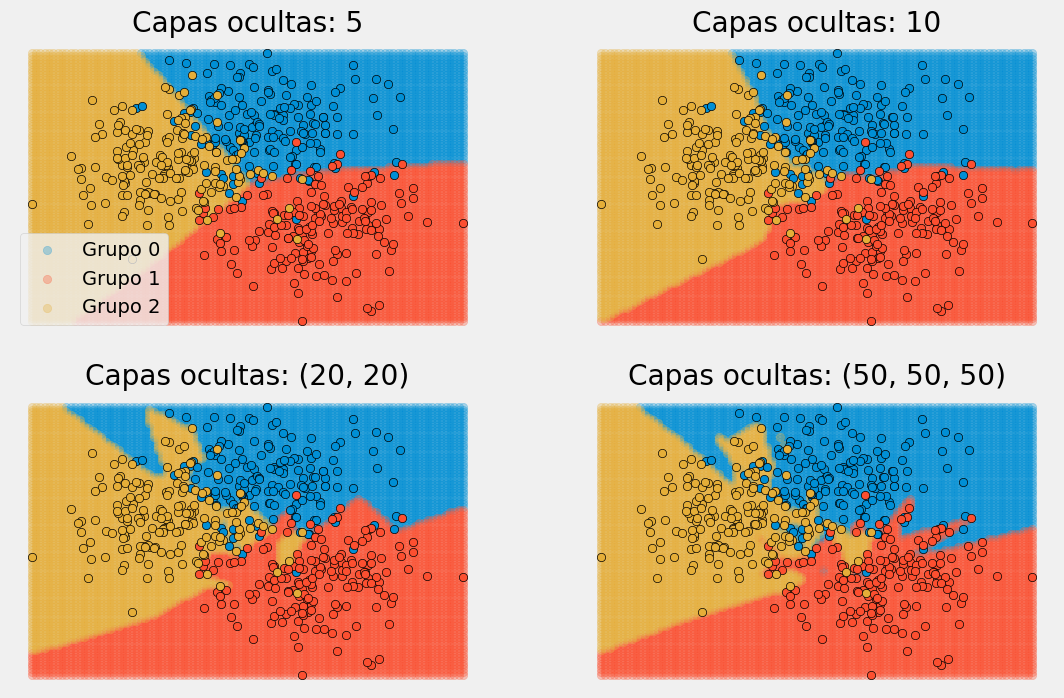

In [4]:
# Gráfico de predicciones
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs = axs.flatten()
grid_x1 = np.linspace(start=min(X[:, 0]), stop=max(X[:, 0]), num=100)
grid_x2 = np.linspace(start=min(X[:, 1]), stop=max(X[:, 1]), num=100)
xx, yy = np.meshgrid(grid_x1, grid_x2)
X_grid = np.column_stack([xx.flatten(), yy.flatten()])

for i, modelo in enumerate([modelo_1, modelo_2, modelo_3, modelo_4]):
    
    predicciones = modelo.predict(X_grid)
    
    for j in np.unique(predicciones):
        axs[i].scatter(
            x = X_grid[predicciones == j, 0],
            y = X_grid[predicciones == j, 1], 
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j],
            #marker = 'o',
            alpha = 0.3,
            label= f"Grupo {j}"
        )

    for j in np.unique(y):
        axs[i].scatter(
            x = X[y == j, 0],
            y = X[y == j, 1], 
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j],
            marker    = 'o',
            edgecolor = 'black'
        )
        
    axs[i].set_title(f"Capas ocultas: {modelo.hidden_layer_sizes}")
    axs[i].axis('off')
axs[0].legend();

In [5]:
# Número de neuronas
# ==============================================================================
param_grid = {'hidden_layer_sizes':[1, 5, 10, 15, 25, 50]}

grid = GridSearchCV(
        estimator = MLPClassifier(
                        learning_rate_init=0.01,
                        solver = 'lbfgs',
                        alpha  = 0,
                        max_iter = 5000,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 5,
        refit      = True,
        return_train_score = True
      )

_ = grid.fit(X, y)

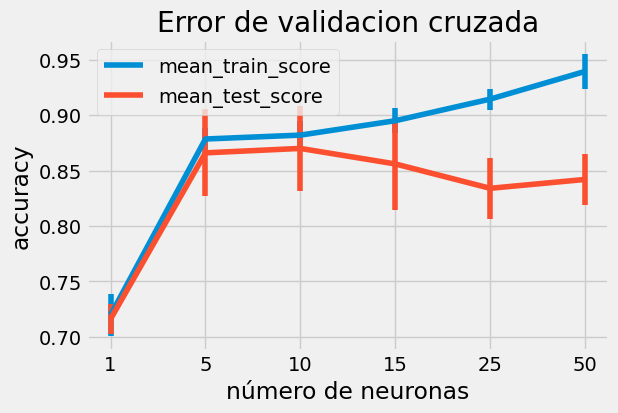

In [6]:
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_hidden_layer_sizes', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_hidden_layer_sizes', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_ylabel('accuracy')
ax.set_xlabel('número de neuronas')
ax.set_title('Error de validacion cruzada');

In [7]:
# learning rate
# ==============================================================================
param_grid = {'learning_rate_init':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(
        estimator = MLPClassifier(
                        hidden_layer_sizes=(10),
                        solver = 'adam',
                        alpha  = 0,
                        max_iter = 5000,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 5,
        refit      = True,
        return_train_score = True
      )

_ = grid.fit(X, y)

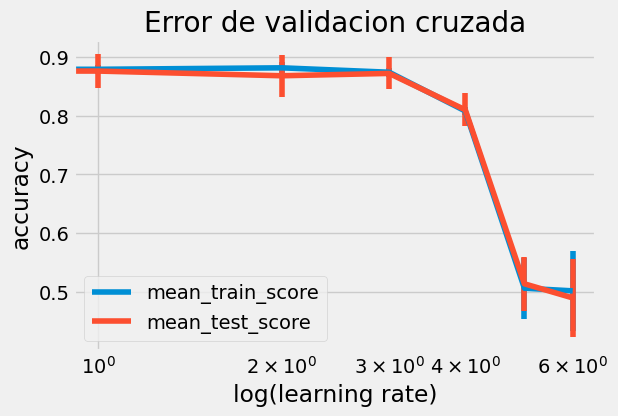

In [8]:
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_learning_rate_init', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_learning_rate_init', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_xscale('log')
ax.set_xlabel('log(learning rate)')
ax.set_ylabel('accuracy')
ax.set_title('Error de validacion cruzada');

Si bien los dos ejemplos anteriores sirven para tener una idea intuitiva de cómo afecta cada hiperparámetro, no es posible optimizarlos de forma individual, ya que el impacto final que tiene cada uno depende de qué valor tomen los demás. La búsqueda de hiperparámetros debe hacerse en conjunto.


Dado el elevado número de hiperparámetros que tiene los modelos de redes neuronales, la combinación de posibles configuraciones es muy elevada. Esto hace que la búsqueda de hiperparámetros por grid search cartesiano (todas las combinaciones) sea poco práctica. En su lugar, suele emplearse random grid search, que hace una búsqueda de combinaciones aleatorias. Para más información sobre esta y otras estrategias de búsqueda consultar Hiperparámetros (tuning)).

In [9]:
# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {
    'hidden_layer_sizes': [(10), (10, 10), (20, 20)],
    'alpha': np.logspace(-3, 3, 7),
    'learning_rate_init': [0.001, 0.01, 0.1],
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = MLPClassifier(solver = 'lbfgs', max_iter= 2000),
        param_distributions = param_distributions,
        n_iter     = 50, # Número máximo de combinaciones probadas
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 3, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X, y = y)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

,param_learning_rate_init,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
30,0.01,10,10.0,0.869923,0.032214,0.875978,0.021527
49,0.1,10,100.0,0.869899,0.042016,0.873973,0.021077
46,0.01,10,100.0,0.869899,0.042016,0.873973,0.021077
17,0.01,10,0.01,0.865919,0.041054,0.884978,0.027084
7,0.01,"(10, 10)",10.0,0.863923,0.038326,0.879985,0.021309
41,0.001,10,10.0,0.863923,0.035070,0.876979,0.021892
4,0.01,"(20, 20)",10.0,0.863923,0.035070,0.880980,0.022338
34,0.1,"(10, 10)",10.0,0.863923,0.035070,0.878975,0.022356
21,0.1,"(20, 20)",10.0,0.863923,0.035070,0.880977,0.024650
1,0.001,"(10, 10)",10.0,0.861927,0.035614,0.877977,0.022883


La combinación de hiperparámetros que mejores resultados consigue es:

In [10]:
modelo = grid.best_estimator_
modelo

MLPClassifier(alpha=10.0, hidden_layer_sizes=10, learning_rate_init=0.01,
              max_iter=2000, solver='lbfgs')

Una vez entrenado el modelo, al tratarse de solo dos predictores, puede mostrarse gráficamente las regiones de clasificación aprendidas.

In [11]:
grid_x1 = np.linspace(start=min(X[:, 0]), stop=max(X[:, 0]), num=100)
grid_x2 = np.linspace(start=min(X[:, 1]), stop=max(X[:, 1]), num=100)
xx, yy = np.meshgrid(grid_x1, grid_x2)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])
predicciones = modelo.predict(X_grid)

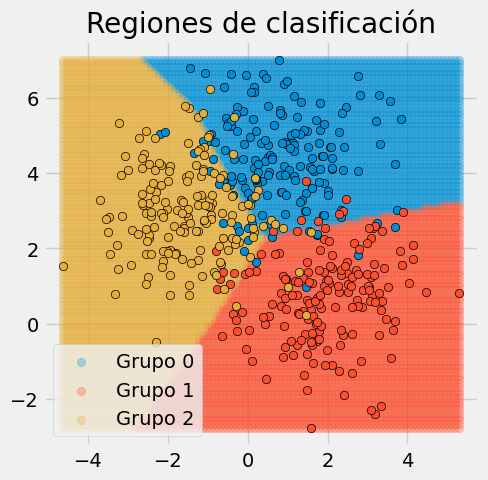

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in np.unique(predicciones):
    ax.scatter(
        x = X_grid[predicciones == i, 0],
        y = X_grid[predicciones == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        #marker = 'o',
        alpha = 0.3,
        label= f"Grupo {i}"
    )

for i in np.unique(y):
    ax.scatter(
        x = X[y == i, 0],
        y = X[y == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black'
    )
    

ax.set_title('Regiones de clasificación')
ax.legend();